# MixedWM38 Preprocessing

This notebook contains the preprocessing steps for the MixedWM38 dataset. We walk through the steps of loading the data, cleaning it, and saving it in a format that is ready for use.

In [ ]:
# !pip install --upgrade kaggle pandas scikit-multilearn

## Imports

In [1]:
import os

import kaggle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skmultilearn.model_selection import iterative_train_test_split
from ssl_wafermap.utilities.transforms import rgb_scale

## Downloading the Data

The dataset is publicly availble at https://www.kaggle.com/datasets/co1d7era/mixedtype-wafer-defect-datasets, and we're after the `Wafer_Map_Dataset.npz` file. All files in the Kaggle dataset can be downloaded using the Kaggle API.

In [2]:
save_path = "../data/raw/MixedWM38/"
dataset = "co1d7era/mixedtype-wafer-defect-datasets"

kaggle.api.authenticate()
kaggle.api.dataset_download_files(dataset, path=save_path, quiet=False, unzip=True)

100%|██████████| 21.8M/21.8M [00:00<00:00, 46.1MB/s]


## Splitting the Data

Now we load the npz file and split it into training, validation, and test sets. We also save the data in a format that is ready for use.

In [3]:
data = np.load(os.path.join(save_path, "Wafer_Map_Datasets.npz"))
# data.files -> ['arr_0', 'arr_1']
wafer_maps = data["arr_0"]
labels = data["arr_1"]

We'll use the `iterative_train_test_split` function from scikit-multilearn to split the data into training, validation, and test sets. Because this is a multilabel problem, it's a bit nontrivial to split the data in a stratified fashion. This niche library provides a function that does exactly that, although it won't exactly split the data into 70/15/15 splits, which is okay.

In [4]:
# Make the test set 15% of the data
X_train_val, y_train_val, X_test, y_test = iterative_train_test_split(
    wafer_maps, labels, test_size=15 / 100
)
# From the remaining 85%, make the validation set 15% of the *total* data
X_train, y_train, X_val, y_val = iterative_train_test_split(
    X_train_val, y_train_val, test_size=15 / 85
)

# Now we create smaller splits for fine-tuning self-supervised models
# We want splits that roughly correspond to 1%, 5%, 10%, and 20% of the training data

# From the training data (~70%), make the 1% split
X_train_69, y_train_69, X_train_1, y_train_1 = iterative_train_test_split(
    X_train, y_train, test_size=1 / 70
)
# Grab a 5% split from the ~69% remaining
X_train_64, y_train_64, X_train_5, y_train_5 = iterative_train_test_split(
    X_train_69, y_train_69, test_size=5 / 69
)
# Grab a 10% split from the ~64% remaining
X_train_54, y_train_54, X_train_10, y_train_10 = iterative_train_test_split(
    X_train_64, y_train_64, test_size=10 / 64
)
# Grab a 20% split from the ~54% remaining
X_train_34, y_train_34, X_train_20, y_train_20 = iterative_train_test_split(
    X_train_54, y_train_54, test_size=20 / 54
)

# Print out the true fractions of each split
for split in (
    X_train,
    X_val,
    X_test,
    X_train_1,
    X_train_5,
    X_train_10,
    X_train_20,
):
    split_name = [k for k, v in locals().items() if v is split][0]
    length = len(split)
    fraction = length / len(wafer_maps)
    print(f"{split_name}: {length} samples ({fraction:.2%})")

X_train: 26157 samples (68.81%)
X_val: 5606 samples (14.75%)
X_test: 6252 samples (16.45%)
X_train_1: 374 samples (0.98%)
X_train_5: 1869 samples (4.92%)
X_train_10: 4225 samples (11.11%)
X_train_20: 7293 samples (19.18%)


Now that we have the splits, we'll create Pandas dataframes out of all of them and save them to disk.

In [5]:
data_path = "../data/processed/MixedWM38/"
os.makedirs(os.path.join(os.getcwd(), data_path), exist_ok=True)

for x, y in zip(
    (
        X_train_1,
        X_train_5,
        X_train_10,
        X_train_20,
        X_train,
        X_val,
        X_test,
    ),
    (
        y_train_1,
        y_train_5,
        y_train_10,
        y_train_20,
        y_train,
        y_val,
        y_test,
    ),
):
    # Converting from arrays to lists of arrays is better for dataframe creation
    # For the wafer maps, use rgb_scale to go from [0, 1, 2] to [0, 128, 255]
    wafers = [rgb_scale(wafer) for wafer in x]  
    labels = [label for label in y]

    df = pd.DataFrame({"waferMap": wafers, "label": labels})
    split_name = [k for k, v in locals().items() if v is x][0]

    # For X_train, X_val, X_test, the save_name should be train_data, val_data, test_data
    # For X_train_1, X_train_5, etc., the save_name should be train_1_split, train_5_split, etc.
    if any(char.isdigit() for char in split_name):
        save_name = f"train_{split_name.split('_')[-1]}_split"
    else:
        save_name = f"{split_name.split('_')[1]}_data"

    print(save_name)
    display(df)

    # Save the data to a compressed pickle file
    df.to_pickle(f"../data/processed/MixedWM38/{save_name}.pkl.xz", compression="xz")

    # As a sanity check, load the data back in and make sure it's the same
    read_df = pd.read_pickle(f"../data/processed/MixedWM38/{save_name}.pkl.xz")
    assert df.equals(read_df), f"{save_name} is not the same after saving and loading!"

train_1_split


,waferMap,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
...,...,...
369,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 1, 0, 0]"
370,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 1, 0, 0]"
371,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
372,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"


train_5_split


,waferMap,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
...,...,...
1864,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
1865,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
1866,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
1867,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"


train_10_split


,waferMap,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
...,...,...
4220,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
4221,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
4222,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
4223,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"


train_20_split


,waferMap,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
...,...,...
7288,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
7289,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
7290,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
7291,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"


train_data


,waferMap,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
...,...,...
26152,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
26153,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
26154,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
26155,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"


val_data


,waferMap,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
...,...,...
5601,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
5602,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
5603,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
5604,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"


test_data


,waferMap,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
...,...,...
6247,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 1, 0, 0]"
6248,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 1, 0, 0]"
6249,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 1, 0, 0]"
6250,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 1, 0, 0]"


As another sanity check, we'll print out the unique values of the wafer maps (which should be [0, 128, 255]) and plot one.

Unique values in the waferMap: [  0 128 255]
Label: [1 0 0 0 1 0 0 0]


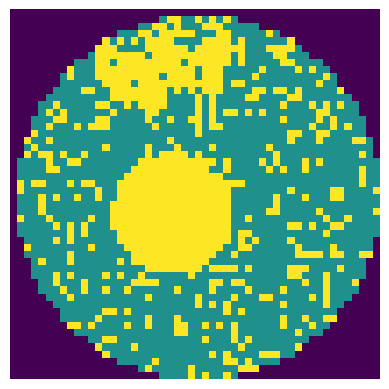

In [38]:
sample = df.sample(1).iloc[0]

print(f"Unique values in the waferMap: {np.unique(sample['waferMap'])}")

print(f"Label: {sample['label']}")
plt.imshow(sample["waferMap"])
plt.axis("off")
plt.show()